In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kerastuner as kt
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score ,recall_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from numpy import average


In [2]:
df= pd.read_csv("Full_LSTM_Classification.csv")
DX=pd.read_csv("DX_Four_Classes.csv")
df=df.sort_values(by='RID', ascending=True)
DX=DX.sort_values(by='RID', ascending=True)
groupby=df.groupby("RID").count()
len(groupby)

1371

In [3]:
test= pd.read_csv("DX_test_four_classes.csv")
df1=pd.merge(df, test, on='RID', how='inner')
for j in range(0,len(test)):
    df=df[df.RID!=test['RID'][j]]

In [4]:
y_test = pd.merge(DX, test, on='RID', how='inner')                        
for j in range(0,len(test)):
    DX=DX[DX.RID!=test['RID'][j]]

In [5]:
df=df.sort_values(by='RID', ascending=True)
X_train1=df.drop(['RID','VISCODE2'],axis = 1 )

In [6]:
df1=df1.sort_values(by='RID', ascending=True)
X_test1=df1.drop(['RID','VISCODE2'],axis = 1 )

In [7]:
num_features=len(X_train1.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train1)
scaler1 = MinMaxScaler(feature_range=(0, 1))
X_test = scaler1.fit_transform(X_test1)


In [8]:
X_train= X_train.reshape(len(DX), 4*num_features)
DX=DX.sort_values(by='RID', ascending=True)
train_label=DX.drop(['RID'],axis = 1 )
X_test= X_test.reshape(len(y_test), 4*num_features)
test_label1=y_test.sort_values(by='RID', ascending=True)
test_label=test_label1.drop(['RID'],axis = 1 )

In [9]:
encoder = LabelEncoder()
encoder.fit(train_label)
encoded_Y= encoder.transform(train_label)
y_train = np_utils.to_categorical(encoded_Y)
encoder1 = LabelEncoder()
encoder1.fit(test_label)
y_test = encoder.transform(test_label)



C:\Users\hager\anaconda3\envs\hager\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:

def build_model(hp):
    num_units_min  =  100
    num_units_max  =  800
    num_units_step =  50

    dropout_min  =  .2
    dropout_max  =  0.9
    dropout_step =  0.1
    
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('unit1',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                 activation='relu',
                                                 input_dim=4* num_features, 
                                                kernel_initializer='random_normal', bias_initializer='zeros',
                                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate',values=[0.01,0.02, 0.05, 0.1,.04,.03]))
                          
                                               ))
    model.add(layers.Dropout(hp.Float('dropout_1',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )
 
 
   
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(units=hp.Int('unitsdense_'+ str(i),
                                            min_value=100,
                                            max_value=800,
                                            step=50),
                                            activation='relu',
                               kernel_initializer='random_normal', bias_initializer='zeros',
                              kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate1'+ str(i),values=[0.01,0.02, 0.05, 0.1,.04,.03]))))   
        model.add(layers.Dropout(hp.Float('dropoutdense_'+ str(i), 
                                      min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step)))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[ 1e-4])),
       loss='categorical_crossentropy', 
       metrics=['acc',f1_m,precision_m, recall_m])
    return model



In [12]:
X_t, X_val, y_t, y_val = train_test_split(
     X_train, y_train, test_size=0.10, stratify= y_train, shuffle=True, random_state=None) 
len(X_t)

1109

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials=2,
    project_name='feedffull4')

INFO:tensorflow:Reloading Oracle from existing project .\feedffull4\oracle.json
INFO:tensorflow:Reloading Tuner from .\feedffull4\tuner0.json


In [14]:

early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1)
callback_list = [ early_stopping ]
h=tuner.search(X_t, y_t,
             epochs=100,
             batch_size=50, 
             callbacks=callback_list, validation_data=(X_val,y_val) )
            
model = tuner.get_best_models(num_models=1)[0]


INFO:tensorflow:Oracle triggered exit

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x00000169DED1BE20> and <tensorflow.python.keras.layers.core.Dropout object at 0x00000169DED35FA0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x00000169DEEA9070> and <tensorflow.python.keras.layers.core.Dropout object at 0x00000169DECA5A00>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x00000169DEEA6940> and <tensorflow.python.keras.layers.core.Dropout object at 0x00000169DEEB9EB0>).


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               264500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               300600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               240400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1

In [16]:
tuner.get_best_hyperparameters()[0].values

{'unit1': 500,
 'reg_rate': 0.01,
 'dropout_1': 0.30000000000000004,
 'num_layers': 2,
 'unitsdense_0': 600,
 'reg_rate10': 0.05,
 'dropoutdense_0': 0.7000000000000002,
 'learning_rate': 0.0001,
 'unitsdense_1': 400,
 'reg_rate11': 0.01,
 'dropoutdense_1': 0.8000000000000003,
 'unitsdense_2': 700,
 'reg_rate12': 0.05,
 'dropoutdense_2': 0.30000000000000004}

In [17]:
#model.reset_states()
history= model.fit(X_t, y_t, epochs=120, batch_size=50,  verbose=1,shuffle=True, validation_data=(X_val,y_val))


Epoch 1/120
23/23 [==============================] - 5s 117ms/step - loss: 2.3011 - acc: 0.7969 - f1_m: 0.7880 - precision_m: 0.8433 - recall_m: 0.7401 - val_loss: 2.1879 - val_acc: 0.8306 - val_f1_m: 0.8360 - val_precision_m: 0.8801 - val_recall_m: 0.7972
Epoch 2/120
23/23 [==============================] - 0s 17ms/step - loss: 2.2220 - acc: 0.8170 - f1_m: 0.8103 - precision_m: 0.8541 - recall_m: 0.7711 - val_loss: 2.1396 - val_acc: 0.8145 - val_f1_m: 0.8249 - val_precision_m: 0.8715 - val_recall_m: 0.7839
Epoch 3/120
23/23 [==============================] - 0s 18ms/step - loss: 2.1969 - acc: 0.8156 - f1_m: 0.8032 - precision_m: 0.8503 - recall_m: 0.7620 - val_loss: 2.0989 - val_acc: 0.8306 - val_f1_m: 0.8360 - val_precision_m: 0.8801 - val_recall_m: 0.7972
Epoch 4/120
23/23 [==============================] - 1s 22ms/step - loss: 2.1661 - acc: 0.7894 - f1_m: 0.7801 - precision_m: 0.8303 - recall_m: 0.7366 - val_loss: 2.0526 - val_acc: 0.8226 - val_f1_m: 0.8201 - val_precision_m: 0.876

Epoch 33/120
23/23 [==============================] - 0s 22ms/step - loss: 1.3410 - acc: 0.8232 - f1_m: 0.8188 - precision_m: 0.8593 - recall_m: 0.7827 - val_loss: 1.3342 - val_acc: 0.7903 - val_f1_m: 0.7867 - val_precision_m: 0.8584 - val_recall_m: 0.7289
Epoch 34/120
23/23 [==============================] - 1s 25ms/step - loss: 1.3392 - acc: 0.8061 - f1_m: 0.8105 - precision_m: 0.8599 - recall_m: 0.7671 - val_loss: 1.2820 - val_acc: 0.8065 - val_f1_m: 0.8025 - val_precision_m: 0.8376 - val_recall_m: 0.7706
Epoch 35/120
23/23 [==============================] - 0s 19ms/step - loss: 1.3193 - acc: 0.8059 - f1_m: 0.8071 - precision_m: 0.8496 - recall_m: 0.7693 - val_loss: 1.2610 - val_acc: 0.8145 - val_f1_m: 0.8193 - val_precision_m: 0.8585 - val_recall_m: 0.7839
Epoch 36/120
23/23 [==============================] - 0s 16ms/step - loss: 1.2748 - acc: 0.8268 - f1_m: 0.8333 - precision_m: 0.8823 - recall_m: 0.7901 - val_loss: 1.2750 - val_acc: 0.8065 - val_f1_m: 0.7903 - val_precision_m: 0.

Epoch 65/120
23/23 [==============================] - 0s 15ms/step - loss: 0.9834 - acc: 0.8310 - f1_m: 0.8325 - precision_m: 0.8737 - recall_m: 0.7957 - val_loss: 0.9812 - val_acc: 0.7823 - val_f1_m: 0.8009 - val_precision_m: 0.8422 - val_recall_m: 0.7639
Epoch 66/120
23/23 [==============================] - 0s 15ms/step - loss: 0.9730 - acc: 0.8316 - f1_m: 0.8374 - precision_m: 0.8746 - recall_m: 0.8037 - val_loss: 0.9756 - val_acc: 0.7903 - val_f1_m: 0.8171 - val_precision_m: 0.8700 - val_recall_m: 0.7706
Epoch 67/120
23/23 [==============================] - 0s 16ms/step - loss: 0.9500 - acc: 0.8291 - f1_m: 0.8295 - precision_m: 0.8724 - recall_m: 0.7911 - val_loss: 0.9597 - val_acc: 0.8065 - val_f1_m: 0.8193 - val_precision_m: 0.8585 - val_recall_m: 0.7839
Epoch 68/120
23/23 [==============================] - 0s 15ms/step - loss: 0.9212 - acc: 0.8614 - f1_m: 0.8524 - precision_m: 0.8955 - recall_m: 0.8145 - val_loss: 0.9844 - val_acc: 0.7984 - val_f1_m: 0.7726 - val_precision_m: 0.

23/23 [==============================] - 1s 23ms/step - loss: 0.8153 - acc: 0.8399 - f1_m: 0.8400 - precision_m: 0.8846 - recall_m: 0.8003 - val_loss: 0.8401 - val_acc: 0.7903 - val_f1_m: 0.7970 - val_precision_m: 0.8421 - val_recall_m: 0.7567
Epoch 97/120
23/23 [==============================] - 1s 23ms/step - loss: 0.8094 - acc: 0.8487 - f1_m: 0.8539 - precision_m: 0.8893 - recall_m: 0.8219 - val_loss: 0.8392 - val_acc: 0.7903 - val_f1_m: 0.7996 - val_precision_m: 0.8480 - val_recall_m: 0.7567
Epoch 98/120
23/23 [==============================] - 0s 18ms/step - loss: 0.8364 - acc: 0.8265 - f1_m: 0.8261 - precision_m: 0.8738 - recall_m: 0.7839 - val_loss: 0.8299 - val_acc: 0.7823 - val_f1_m: 0.8052 - val_precision_m: 0.8433 - val_recall_m: 0.7706
Epoch 99/120
23/23 [==============================] - 0s 17ms/step - loss: 0.8278 - acc: 0.8261 - f1_m: 0.8313 - precision_m: 0.8638 - recall_m: 0.8016 - val_loss: 0.8501 - val_acc: 0.7903 - val_f1_m: 0.7793 - val_precision_m: 0.8297 - val_re

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


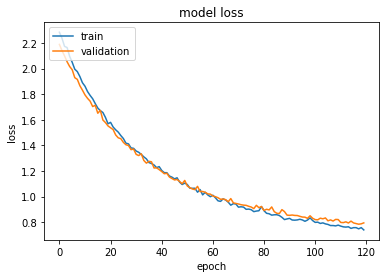

In [18]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
my_dict_Train={"Accuracy_Train": [],"Precision_Train": [],"Recall_Train": [], "F1_score_Train":[]};
my_dict_STD={"Accuracy_Train": [],"Precision_Train": [],"Recall_Train": [], "F1_score_Train":[]};
my_dict_Test={"Accuracy_Test": [],"Precision_Test": [],"Recall_Test": [], "F1_score_Test":[]};

In [20]:
for i in range(0,10):
        from sklearn.model_selection import StratifiedKFold
        if i==0:
            r=70
        elif i== 1:
            r=80
        elif i== 2:
            r=90
        elif i== 3:
            r=100
        elif i== 4:
            r=130
        elif i==6:
            r=120
        elif i==7:
            r=50
        elif i==8:
            r=60
        elif i==9:
            r=30
        elif i==5:
            r=10
        
        X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.10, stratify= y_train, shuffle=True, random_state=r)
        h=model.fit(X_t, y_t, epochs=50, batch_size=50,  verbose=1,shuffle=True, validation_data=(X_val,y_val))

        my_dict_Train["Accuracy_Train"].append(round(100*np.mean(h.history['val_acc']),2))
        my_dict_STD["Accuracy_Train"].append(round(100*np.std(h.history['val_acc']), 2))
        my_dict_Train["Precision_Train"].append(round(100*np.mean(h.history['val_precision_m']),2))
        my_dict_STD["Precision_Train"].append(round(100*np.std(h.history['val_precision_m']), 2))
        my_dict_Train["Recall_Train"].append(round(100*np.mean(h.history['val_recall_m']),2))
        my_dict_STD["Recall_Train"].append(round(100*np.std(h.history['val_recall_m']), 2))
        my_dict_Train["F1_score_Train"].append(round(100*np.mean(h.history['val_f1_m']),2))
        my_dict_STD["F1_score_Train"].append(round(100*np.std(h.history['val_f1_m']), 2))
        y_p = model.predict(X_test)
        y_pred= np.argmax(y_p, axis=1)
        my_dict_Test["Accuracy_Test"].append(round(100*accuracy_score(y_test,y_pred), 2))
        my_dict_Test["Precision_Test"].append(round(100*precision_score(y_test, y_pred, average='weighted'), 2))
        my_dict_Test["Recall_Test"].append(round(100*recall_score(y_test, y_pred, average='weighted'), 2))
        my_dict_Test["F1_score_Test"].append(round(100*f1_score(y_test, y_pred, average='weighted') , 2))

Epoch 1/50
23/23 [==============================] - 0s 17ms/step - loss: 0.7770 - acc: 0.8188 - f1_m: 0.8248 - precision_m: 0.8641 - recall_m: 0.7900 - val_loss: 0.6706 - val_acc: 0.8790 - val_f1_m: 0.8720 - val_precision_m: 0.8933 - val_recall_m: 0.8522
Epoch 2/50
23/23 [==============================] - 0s 15ms/step - loss: 0.7639 - acc: 0.8305 - f1_m: 0.8203 - precision_m: 0.8682 - recall_m: 0.7793 - val_loss: 0.6589 - val_acc: 0.8871 - val_f1_m: 0.8819 - val_precision_m: 0.9070 - val_recall_m: 0.8589
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 0.7470 - acc: 0.8431 - f1_m: 0.8469 - precision_m: 0.8921 - recall_m: 0.8069 - val_loss: 0.6629 - val_acc: 0.8790 - val_f1_m: 0.8749 - val_precision_m: 0.8997 - val_recall_m: 0.8522
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 0.7631 - acc: 0.8305 - f1_m: 0.8329 - precision_m: 0.8750 - recall_m: 0.7952 - val_loss: 0.6682 - val_acc: 0.8710 - val_f1_m: 0.8750 - val_precision_m: 0.8998 - v

23/23 [==============================] - 0s 22ms/step - loss: 0.7024 - acc: 0.8323 - f1_m: 0.8328 - precision_m: 0.8729 - recall_m: 0.7964 - val_loss: 0.6292 - val_acc: 0.8710 - val_f1_m: 0.8720 - val_precision_m: 0.8933 - val_recall_m: 0.8522
Epoch 34/50
23/23 [==============================] - 0s 22ms/step - loss: 0.6862 - acc: 0.8440 - f1_m: 0.8462 - precision_m: 0.8838 - recall_m: 0.8121 - val_loss: 0.6244 - val_acc: 0.8710 - val_f1_m: 0.8720 - val_precision_m: 0.8933 - val_recall_m: 0.8522
Epoch 35/50
23/23 [==============================] - 1s 24ms/step - loss: 0.6867 - acc: 0.8521 - f1_m: 0.8382 - precision_m: 0.8852 - recall_m: 0.7981 - val_loss: 0.6462 - val_acc: 0.8710 - val_f1_m: 0.8759 - val_precision_m: 0.8940 - val_recall_m: 0.8589
Epoch 36/50
23/23 [==============================] - 0s 21ms/step - loss: 0.7064 - acc: 0.8413 - f1_m: 0.8431 - precision_m: 0.8867 - recall_m: 0.8043 - val_loss: 0.6315 - val_acc: 0.8710 - val_f1_m: 0.8770 - val_precision_m: 0.8889 - val_recal

23/23 [==============================] - 0s 20ms/step - loss: 0.6536 - acc: 0.8395 - f1_m: 0.8419 - precision_m: 0.8842 - recall_m: 0.8043 - val_loss: 0.6123 - val_acc: 0.8871 - val_f1_m: 0.8573 - val_precision_m: 0.8786 - val_recall_m: 0.8372
Epoch 16/50
23/23 [==============================] - 1s 22ms/step - loss: 0.6674 - acc: 0.8323 - f1_m: 0.8403 - precision_m: 0.8812 - recall_m: 0.8039 - val_loss: 0.5983 - val_acc: 0.8871 - val_f1_m: 0.8605 - val_precision_m: 0.8853 - val_recall_m: 0.8372
Epoch 17/50
23/23 [==============================] - 0s 18ms/step - loss: 0.6565 - acc: 0.8431 - f1_m: 0.8452 - precision_m: 0.8813 - recall_m: 0.8126 - val_loss: 0.5991 - val_acc: 0.8790 - val_f1_m: 0.8573 - val_precision_m: 0.8786 - val_recall_m: 0.8372
Epoch 18/50
23/23 [==============================] - 0s 21ms/step - loss: 0.6621 - acc: 0.8359 - f1_m: 0.8413 - precision_m: 0.8785 - recall_m: 0.8082 - val_loss: 0.6154 - val_acc: 0.8710 - val_f1_m: 0.8495 - val_precision_m: 0.8772 - val_recal

23/23 [==============================] - 0s 17ms/step - loss: 0.6372 - acc: 0.8422 - f1_m: 0.8529 - precision_m: 0.8953 - recall_m: 0.8152 - val_loss: 0.5999 - val_acc: 0.8710 - val_f1_m: 0.8520 - val_precision_m: 0.8903 - val_recall_m: 0.8172
Epoch 48/50
23/23 [==============================] - 0s 19ms/step - loss: 0.6223 - acc: 0.8440 - f1_m: 0.8530 - precision_m: 0.8973 - recall_m: 0.8134 - val_loss: 0.5948 - val_acc: 0.8790 - val_f1_m: 0.8535 - val_precision_m: 0.8780 - val_recall_m: 0.8306
Epoch 49/50
23/23 [==============================] - 0s 20ms/step - loss: 0.6333 - acc: 0.8377 - f1_m: 0.8366 - precision_m: 0.8770 - recall_m: 0.8003 - val_loss: 0.6273 - val_acc: 0.8629 - val_f1_m: 0.8373 - val_precision_m: 0.8589 - val_recall_m: 0.8172
Epoch 50/50
23/23 [==============================] - 0s 20ms/step - loss: 0.6246 - acc: 0.8467 - f1_m: 0.8485 - precision_m: 0.8908 - recall_m: 0.8108 - val_loss: 0.5975 - val_acc: 0.8790 - val_f1_m: 0.8495 - val_precision_m: 0.8772 - val_recal

23/23 [==============================] - 0s 18ms/step - loss: 0.6321 - acc: 0.8377 - f1_m: 0.8429 - precision_m: 0.8773 - recall_m: 0.8117 - val_loss: 0.5856 - val_acc: 0.8387 - val_f1_m: 0.8632 - val_precision_m: 0.8980 - val_recall_m: 0.8311
Epoch 30/50
23/23 [==============================] - 0s 20ms/step - loss: 0.6102 - acc: 0.8539 - f1_m: 0.8482 - precision_m: 0.8918 - recall_m: 0.8107 - val_loss: 0.6098 - val_acc: 0.8226 - val_f1_m: 0.8349 - val_precision_m: 0.8684 - val_recall_m: 0.8039
Epoch 31/50
23/23 [==============================] - 0s 20ms/step - loss: 0.6331 - acc: 0.8431 - f1_m: 0.8378 - precision_m: 0.8738 - recall_m: 0.8056 - val_loss: 0.5896 - val_acc: 0.8468 - val_f1_m: 0.8571 - val_precision_m: 0.8848 - val_recall_m: 0.8311
Epoch 32/50
23/23 [==============================] - 0s 19ms/step - loss: 0.6198 - acc: 0.8422 - f1_m: 0.8443 - precision_m: 0.8785 - recall_m: 0.8134 - val_loss: 0.6005 - val_acc: 0.8387 - val_f1_m: 0.8563 - val_precision_m: 0.8908 - val_recal

C:\Users\hager\anaconda3\envs\hager\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


23/23 [==============================] - 0s 22ms/step - loss: 0.5908 - acc: 0.8539 - f1_m: 0.8539 - precision_m: 0.8895 - recall_m: 0.8216 - val_loss: 0.5834 - val_acc: 0.8629 - val_f1_m: 0.8849 - val_precision_m: 0.9136 - val_recall_m: 0.8583
Epoch 2/50
23/23 [==============================] - 0s 21ms/step - loss: 0.5900 - acc: 0.8503 - f1_m: 0.8528 - precision_m: 0.8886 - recall_m: 0.8208 - val_loss: 0.5804 - val_acc: 0.8871 - val_f1_m: 0.8779 - val_precision_m: 0.9078 - val_recall_m: 0.8517
Epoch 3/50
23/23 [==============================] - 1s 23ms/step - loss: 0.5884 - acc: 0.8503 - f1_m: 0.8469 - precision_m: 0.8820 - recall_m: 0.8151 - val_loss: 0.5866 - val_acc: 0.8871 - val_f1_m: 0.8798 - val_precision_m: 0.9187 - val_recall_m: 0.8450
Epoch 4/50
23/23 [==============================] - 1s 28ms/step - loss: 0.6007 - acc: 0.8467 - f1_m: 0.8435 - precision_m: 0.8823 - recall_m: 0.8086 - val_loss: 0.5867 - val_acc: 0.8710 - val_f1_m: 0.8700 - val_precision_m: 0.9048 - val_recall_m

23/23 [==============================] - 0s 17ms/step - loss: 0.5712 - acc: 0.8593 - f1_m: 0.8594 - precision_m: 0.9067 - recall_m: 0.8178 - val_loss: 0.5980 - val_acc: 0.8710 - val_f1_m: 0.8658 - val_precision_m: 0.9039 - val_recall_m: 0.8317
Epoch 34/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5859 - acc: 0.8395 - f1_m: 0.8404 - precision_m: 0.8789 - recall_m: 0.8056 - val_loss: 0.6007 - val_acc: 0.8548 - val_f1_m: 0.8658 - val_precision_m: 0.9042 - val_recall_m: 0.8322
Epoch 35/50
23/23 [==============================] - 0s 18ms/step - loss: 0.5954 - acc: 0.8431 - f1_m: 0.8570 - precision_m: 0.8914 - recall_m: 0.8261 - val_loss: 0.5965 - val_acc: 0.8710 - val_f1_m: 0.8801 - val_precision_m: 0.9194 - val_recall_m: 0.8450
Epoch 36/50
23/23 [==============================] - 0s 19ms/step - loss: 0.5686 - acc: 0.8557 - f1_m: 0.8550 - precision_m: 0.8934 - recall_m: 0.8208 - val_loss: 0.6002 - val_acc: 0.8710 - val_f1_m: 0.8700 - val_precision_m: 0.9048 - val_recal

Epoch 15/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5557 - acc: 0.8602 - f1_m: 0.8610 - precision_m: 0.9105 - recall_m: 0.8186 - val_loss: 0.5961 - val_acc: 0.8548 - val_f1_m: 0.8442 - val_precision_m: 0.8651 - val_recall_m: 0.8244
Epoch 16/50
23/23 [==============================] - 0s 20ms/step - loss: 0.5563 - acc: 0.8683 - f1_m: 0.8654 - precision_m: 0.9017 - recall_m: 0.8326 - val_loss: 0.6004 - val_acc: 0.8387 - val_f1_m: 0.8556 - val_precision_m: 0.8738 - val_recall_m: 0.8383
Epoch 17/50
23/23 [==============================] - 1s 22ms/step - loss: 0.5612 - acc: 0.8503 - f1_m: 0.8556 - precision_m: 0.8910 - recall_m: 0.8239 - val_loss: 0.5995 - val_acc: 0.8387 - val_f1_m: 0.8596 - val_precision_m: 0.8748 - val_recall_m: 0.8450
Epoch 18/50
23/23 [==============================] - 0s 19ms/step - loss: 0.5555 - acc: 0.8629 - f1_m: 0.8691 - precision_m: 0.9077 - recall_m: 0.8343 - val_loss: 0.6110 - val_acc: 0.8468 - val_f1_m: 0.8585 - val_precision_m: 0.8799

23/23 [==============================] - 0s 14ms/step - loss: 0.5442 - acc: 0.8611 - f1_m: 0.8738 - precision_m: 0.9058 - recall_m: 0.8452 - val_loss: 0.6219 - val_acc: 0.8306 - val_f1_m: 0.8435 - val_precision_m: 0.8714 - val_recall_m: 0.8178
Epoch 48/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5436 - acc: 0.8575 - f1_m: 0.8645 - precision_m: 0.9030 - recall_m: 0.8296 - val_loss: 0.6250 - val_acc: 0.8468 - val_f1_m: 0.8487 - val_precision_m: 0.8667 - val_recall_m: 0.8317
Epoch 49/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5353 - acc: 0.8602 - f1_m: 0.8658 - precision_m: 0.8993 - recall_m: 0.8357 - val_loss: 0.6260 - val_acc: 0.8387 - val_f1_m: 0.8346 - val_precision_m: 0.8522 - val_recall_m: 0.8178
Epoch 50/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5438 - acc: 0.8593 - f1_m: 0.8517 - precision_m: 0.8866 - recall_m: 0.8203 - val_loss: 0.6305 - val_acc: 0.8306 - val_f1_m: 0.8333 - val_precision_m: 0.8569 - val_recal

23/23 [==============================] - 0s 15ms/step - loss: 0.5307 - acc: 0.8711 - f1_m: 0.8719 - precision_m: 0.9129 - recall_m: 0.8352 - val_loss: 0.6045 - val_acc: 0.8065 - val_f1_m: 0.8148 - val_precision_m: 0.8574 - val_recall_m: 0.7767
Epoch 30/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5285 - acc: 0.8611 - f1_m: 0.8634 - precision_m: 0.8970 - recall_m: 0.8329 - val_loss: 0.6102 - val_acc: 0.7984 - val_f1_m: 0.7956 - val_precision_m: 0.8406 - val_recall_m: 0.7561
Epoch 31/50
23/23 [==============================] - 0s 18ms/step - loss: 0.5351 - acc: 0.8683 - f1_m: 0.8656 - precision_m: 0.9017 - recall_m: 0.8334 - val_loss: 0.6060 - val_acc: 0.8306 - val_f1_m: 0.8178 - val_precision_m: 0.8639 - val_recall_m: 0.7767
Epoch 32/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5354 - acc: 0.8638 - f1_m: 0.8696 - precision_m: 0.9126 - recall_m: 0.8313 - val_loss: 0.6199 - val_acc: 0.7984 - val_f1_m: 0.8125 - val_precision_m: 0.8621 - val_recal

23/23 [==============================] - 0s 22ms/step - loss: 0.5288 - acc: 0.8611 - f1_m: 0.8556 - precision_m: 0.8968 - recall_m: 0.8186 - val_loss: 0.5123 - val_acc: 0.8710 - val_f1_m: 0.8808 - val_precision_m: 0.9120 - val_recall_m: 0.8528
Epoch 12/50
23/23 [==============================] - 0s 18ms/step - loss: 0.5685 - acc: 0.8458 - f1_m: 0.8397 - precision_m: 0.8923 - recall_m: 0.7951 - val_loss: 0.5271 - val_acc: 0.8710 - val_f1_m: 0.8664 - val_precision_m: 0.9040 - val_recall_m: 0.8322
Epoch 13/50
23/23 [==============================] - 0s 20ms/step - loss: 0.5508 - acc: 0.8530 - f1_m: 0.8610 - precision_m: 0.8994 - recall_m: 0.8269 - val_loss: 0.5193 - val_acc: 0.8790 - val_f1_m: 0.8778 - val_precision_m: 0.9057 - val_recall_m: 0.8528
Epoch 14/50
23/23 [==============================] - 1s 22ms/step - loss: 0.5324 - acc: 0.8647 - f1_m: 0.8595 - precision_m: 0.8993 - recall_m: 0.8238 - val_loss: 0.5182 - val_acc: 0.8710 - val_f1_m: 0.8749 - val_precision_m: 0.8991 - val_recal

23/23 [==============================] - 0s 16ms/step - loss: 0.5424 - acc: 0.8557 - f1_m: 0.8522 - precision_m: 0.8839 - recall_m: 0.8234 - val_loss: 0.5519 - val_acc: 0.8468 - val_f1_m: 0.8471 - val_precision_m: 0.8783 - val_recall_m: 0.8183
Epoch 44/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5539 - acc: 0.8476 - f1_m: 0.8423 - precision_m: 0.8828 - recall_m: 0.8060 - val_loss: 0.5831 - val_acc: 0.8387 - val_f1_m: 0.8459 - val_precision_m: 0.8834 - val_recall_m: 0.8117
Epoch 45/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5489 - acc: 0.8422 - f1_m: 0.8498 - precision_m: 0.8874 - recall_m: 0.8160 - val_loss: 0.5651 - val_acc: 0.8548 - val_f1_m: 0.8593 - val_precision_m: 0.8969 - val_recall_m: 0.8250
Epoch 46/50
23/23 [==============================] - 0s 20ms/step - loss: 0.5382 - acc: 0.8548 - f1_m: 0.8551 - precision_m: 0.8930 - recall_m: 0.8213 - val_loss: 0.5224 - val_acc: 0.8548 - val_f1_m: 0.8705 - val_precision_m: 0.9048 - val_recal

23/23 [==============================] - 0s 20ms/step - loss: 0.5226 - acc: 0.8593 - f1_m: 0.8721 - precision_m: 0.9127 - recall_m: 0.8357 - val_loss: 0.5371 - val_acc: 0.8387 - val_f1_m: 0.8496 - val_precision_m: 0.9011 - val_recall_m: 0.8039
Epoch 26/50
23/23 [==============================] - 0s 20ms/step - loss: 0.5061 - acc: 0.8638 - f1_m: 0.8718 - precision_m: 0.9050 - recall_m: 0.8417 - val_loss: 0.5317 - val_acc: 0.8387 - val_f1_m: 0.8496 - val_precision_m: 0.9011 - val_recall_m: 0.8039
Epoch 27/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5222 - acc: 0.8656 - f1_m: 0.8567 - precision_m: 0.8942 - recall_m: 0.8229 - val_loss: 0.5364 - val_acc: 0.8468 - val_f1_m: 0.8496 - val_precision_m: 0.9011 - val_recall_m: 0.8039
Epoch 28/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5365 - acc: 0.8503 - f1_m: 0.8592 - precision_m: 0.8903 - recall_m: 0.8308 - val_loss: 0.5395 - val_acc: 0.8468 - val_f1_m: 0.8427 - val_precision_m: 0.8938 - val_recal

23/23 [==============================] - 0s 16ms/step - loss: 0.5224 - acc: 0.8557 - f1_m: 0.8545 - precision_m: 0.8964 - recall_m: 0.8169 - val_loss: 0.4942 - val_acc: 0.8629 - val_f1_m: 0.8609 - val_precision_m: 0.9024 - val_recall_m: 0.8233
Epoch 8/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5174 - acc: 0.8602 - f1_m: 0.8634 - precision_m: 0.9016 - recall_m: 0.8291 - val_loss: 0.4909 - val_acc: 0.8710 - val_f1_m: 0.8609 - val_precision_m: 0.9024 - val_recall_m: 0.8233
Epoch 9/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5234 - acc: 0.8557 - f1_m: 0.8614 - precision_m: 0.8974 - recall_m: 0.8287 - val_loss: 0.4948 - val_acc: 0.8871 - val_f1_m: 0.8461 - val_precision_m: 0.8866 - val_recall_m: 0.8094
Epoch 10/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5141 - acc: 0.8629 - f1_m: 0.8697 - precision_m: 0.9094 - recall_m: 0.8343 - val_loss: 0.4949 - val_acc: 0.8710 - val_f1_m: 0.8609 - val_precision_m: 0.9024 - val_recall_

23/23 [==============================] - 0s 16ms/step - loss: 0.5291 - acc: 0.8530 - f1_m: 0.8488 - precision_m: 0.8860 - recall_m: 0.8151 - val_loss: 0.5201 - val_acc: 0.8629 - val_f1_m: 0.8461 - val_precision_m: 0.8866 - val_recall_m: 0.8094
Epoch 40/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5158 - acc: 0.8584 - f1_m: 0.8510 - precision_m: 0.8913 - recall_m: 0.8155 - val_loss: 0.5435 - val_acc: 0.8629 - val_f1_m: 0.8441 - val_precision_m: 0.8991 - val_recall_m: 0.7961
Epoch 41/50
23/23 [==============================] - 0s 15ms/step - loss: 0.5207 - acc: 0.8620 - f1_m: 0.8671 - precision_m: 0.9083 - recall_m: 0.8304 - val_loss: 0.5177 - val_acc: 0.8710 - val_f1_m: 0.8551 - val_precision_m: 0.8894 - val_recall_m: 0.8233
Epoch 42/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5051 - acc: 0.8683 - f1_m: 0.8611 - precision_m: 0.8985 - recall_m: 0.8272 - val_loss: 0.5188 - val_acc: 0.8629 - val_f1_m: 0.8461 - val_precision_m: 0.8866 - val_recal

23/23 [==============================] - 0s 16ms/step - loss: 0.5056 - acc: 0.8575 - f1_m: 0.8544 - precision_m: 0.8869 - recall_m: 0.8246 - val_loss: 0.5654 - val_acc: 0.8629 - val_f1_m: 0.8528 - val_precision_m: 0.9009 - val_recall_m: 0.8106
Epoch 22/50
23/23 [==============================] - 0s 15ms/step - loss: 0.4992 - acc: 0.8702 - f1_m: 0.8573 - precision_m: 0.8913 - recall_m: 0.8268 - val_loss: 0.6053 - val_acc: 0.8145 - val_f1_m: 0.8150 - val_precision_m: 0.8680 - val_recall_m: 0.7694
Epoch 23/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5193 - acc: 0.8575 - f1_m: 0.8556 - precision_m: 0.8918 - recall_m: 0.8230 - val_loss: 0.5880 - val_acc: 0.8306 - val_f1_m: 0.8338 - val_precision_m: 0.8852 - val_recall_m: 0.7900
Epoch 24/50
23/23 [==============================] - 0s 17ms/step - loss: 0.5052 - acc: 0.8593 - f1_m: 0.8635 - precision_m: 0.8979 - recall_m: 0.8322 - val_loss: 0.5397 - val_acc: 0.8629 - val_f1_m: 0.8504 - val_precision_m: 0.9137 - val_recal

In [23]:
for metric in my_dict_Train.keys():
    print("%s: %.3f" % (metric, average(my_dict_Train[metric])))
    print("%s: %.3f" % (metric+"_STD", average(my_dict_STD[metric])))

Accuracy_Train: 85.358
Accuracy_Train_STD: 1.223
Precision_Train: 89.056
Precision_Train_STD: 1.236
Recall_Train: 82.009
Recall_Train_STD: 1.182
F1_score_Train: 85.333
F1_score_Train_STD: 1.067


In [24]:
for metric in my_dict_Test.keys():
    print("%s: %.3f" % (metric, average(my_dict_Test[metric])))

Accuracy_Test: 80.000
Precision_Test: 77.785
Recall_Test: 80.000
F1_score_Test: 77.330
